Imports

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson
import warnings

warnings.filterwarnings("ignore")

Initial EDA (Exploratory Data Analysis) & Preprocessing

In [2]:
def make_arabic_readable(text):
    if not isinstance(text, str): return text
    reshaped_text = arabic_reshaper.reshape(text)  # Fixes letter connections
    bidi_text = get_display(reshaped_text)         # Fixes direction (R-to-L)
    return bidi_text

In [3]:
Main_DF = pd.read_excel(r"C:\Work\Programming\Projects\python\Probability & Statstics Proj\Dataset\cairo_accessibility_to_employment_opportunities.xlsx")

Main_DF = Main_DF.replace(to_replace=r'^_x0000_.*', value=np.nan, regex=True)

print(Main_DF.isnull().sum())

ogc_fid            0
gid                0
name_gov           1
zoning_tfc         1
name_tfc         494
name_citya         1
sec_name         160
ssec_name_       160
ssec_nam_1       260
name_compound      0
area_km            0
jobs_total         0
jobs_perc_60       0
pop_2018_c         0
jobs_total_60      0
dtype: int64


In [4]:
TotalNum = Main_DF.shape[0]

for FeatureName, NullNum in Main_DF.isnull().sum().items():
    print(f"{FeatureName}: %{(NullNum/TotalNum) * 100}")

ogc_fid: %0.0
gid: %0.0
name_gov: %0.1529051987767584
zoning_tfc: %0.1529051987767584
name_tfc: %75.53516819571865
name_citya: %0.1529051987767584
sec_name: %24.464831804281346
ssec_name_: %24.464831804281346
ssec_nam_1: %39.75535168195719
name_compound: %0.0
area_km: %0.0
jobs_total: %0.0
jobs_perc_60: %0.0
pop_2018_c: %0.0
jobs_total_60: %0.0


In [5]:
Main_DF.replace(to_replace= np.nan, value= "Unknown", inplace= True)
Main_DF.head(10)

,ogc_fid,gid,name_gov,zoning_tfc,name_tfc,name_citya,sec_name,ssec_name_,ssec_nam_1,name_compound,area_km,jobs_total,jobs_perc_60,pop_2018_c,jobs_total_60
0,1,654,Unknown,Unknown,New Administrative Capital,Unknown,Unknown,Unknown,Unknown,New Administrative Capital,153.243350,0,0.0,0,0.000000
1,2,71,القليوبيه,Inner,Unknown,Qalyoubia_Inner,مركز الخانكه,سرياقوس,Saryaqos,سرياقوس,6.726506,1134,0.0,44667,3897.328775
2,3,87,الجيزه,Outer,Iskan El Niyaba El Idariya,6th of October,Unknown,Unknown,Unknown,Iskan El Niyaba El Idariya,6.616683,0,0.0,386,0.000000
3,4,92,القاهره,Central,Unknown,Cairo_central,قسم الدرب الاحمر,ح الروم,Unknown,ح الروم,0.094619,1174058,19.9,3026,577.999709
4,5,100,القاهره,Central,Unknown,Cairo_central,قسم باب الشعريه,الشمبكى,El Shembky,الشمبكى,0.126626,2053281,34.8,4191,2816.727915
5,6,108,القاهره,Central,Unknown,Cairo_central,قسم الجماليه,الجماليه,El Gamalaia,الجماليه,0.075985,1987330,33.7,3374,371.859589
6,7,112,القاهره,Inner,Unknown,Cairo_Inner,قسم المعادى,معادى السرايات الشرقيه,Mady El Saraiat El Sharkaia,معادى السرايات الشرقيه,3.379522,16565,0.3,25647,18094.355372
7,8,115,القاهره,Central,Unknown,Cairo_central,قسم الساحل,برهام,Borham,برهام,0.456633,2697804,45.8,19379,7467.889344
8,9,117,القاهره,Inner,Unknown,Cairo_Inner,قسم اول مدينه نصر,الحى العاشر,El Hay El Asher,الحى العاشر,5.755099,487,0.0,57943,14077.477750
9,10,122,الجيزه,Outer,South of Wahat Road,6th of October,Unknown,Unknown,Unknown,South of Wahat Road,2.464174,0,0.0,143,0.000000


In [6]:
Categorical_Feats = Main_DF.select_dtypes(include=['object']).columns
print(Main_DF[Categorical_Feats].nunique(axis= 0))

name_gov           6
zoning_tfc         4
name_tfc         148
name_citya        15
sec_name          71
ssec_name_       487
ssec_nam_1       391
name_compound    633
dtype: int64


In [7]:
print(Main_DF.name_gov.unique())
Main_DF.name_gov.replace(to_replace= "الجيزة", value= "الجيزه", inplace= True)
print(Main_DF.name_gov.unique())

['Unknown' 'القليوبيه' 'الجيزه' 'القاهره' 'الجيزة' 'الشرقيه']
['Unknown' 'القليوبيه' 'الجيزه' 'القاهره' 'الشرقيه']


In [8]:
Main_DF["name_gov_ar_fixed"] = Main_DF["name_gov"].apply(make_arabic_readable)
Dropped_Empty_DF = Main_DF[Main_DF.name_gov != "Unknown"]

In [9]:
Inf_Stats_DF = Main_DF.copy()
Non_Clean_Columns = ["name_gov", "zoning_tfc"]

Inf_Stats_DF = Inf_Stats_DF.replace('Unknown', np.nan)

for Col_Name in Non_Clean_Columns:
    Inf_Stats_DF[Col_Name] = Inf_Stats_DF[Col_Name].fillna(Inf_Stats_DF[Col_Name].mode())

Descriptive Statistics 

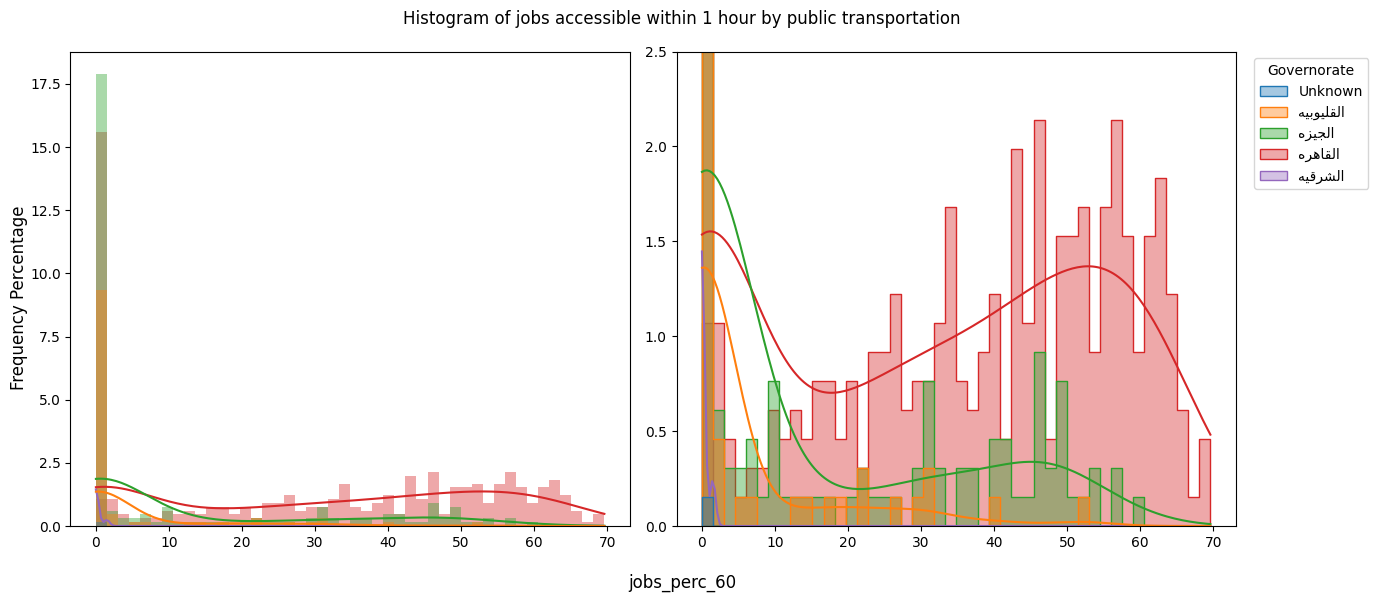

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax = ax.flatten()

fig.suptitle("Histogram of jobs accessible within 1 hour by public transportation")
fig.supxlabel("jobs_perc_60")
fig.supylabel("Frequency Percentage")

sns.histplot(data= Main_DF, x= "jobs_perc_60", kde= True, bins= 30, binwidth= 1.5,
             ax= ax[0], stat= "percent", hue= "name_gov_ar_fixed", legend= False,
             palette="tab10", alpha=0.4, element="step", linewidth=0)
sns.histplot(data= Main_DF, x= "jobs_perc_60", kde= True, bins= 30, binwidth= 1.5,
             ax= ax[1], stat= "percent", hue= "name_gov_ar_fixed", legend= True,
             palette="tab10", alpha=0.4, element="step")

for axis in ax:
    axis.set_xlabel('')
    axis.set_ylabel('')

sns.move_legend(obj= ax[1], loc= "upper left", bbox_to_anchor=(1.02, 1), title="Governorate")

ax[1].set_ylim(0, 2.5)

plt.tight_layout()
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\Histograms_Proj.svg', bbox_inches='tight')
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\Histograms_Proj.png', dpi= 600, bbox_inches='tight')
plt.show()

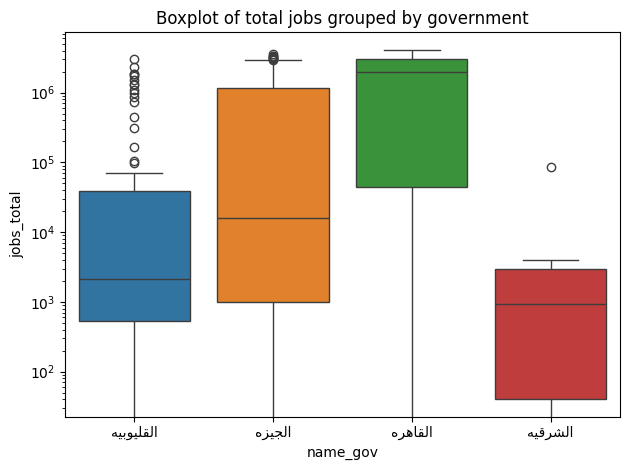

In [11]:
fig, ax = plt.subplots()

sns.boxplot(x= "name_gov_ar_fixed", y= "jobs_total", data= Dropped_Empty_DF, ax= ax, hue= "name_gov_ar_fixed")

ax.set_title("Boxplot of total jobs grouped by government")
ax.set_yscale("log")
ax.set_xlabel("name_gov")
ax.set_ylabel("jobs_total")

plt.tight_layout()
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\Boxplot_Proj.svg', bbox_inches='tight')
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\Boxplot_Proj.png', dpi= 600, bbox_inches='tight')
plt.show()

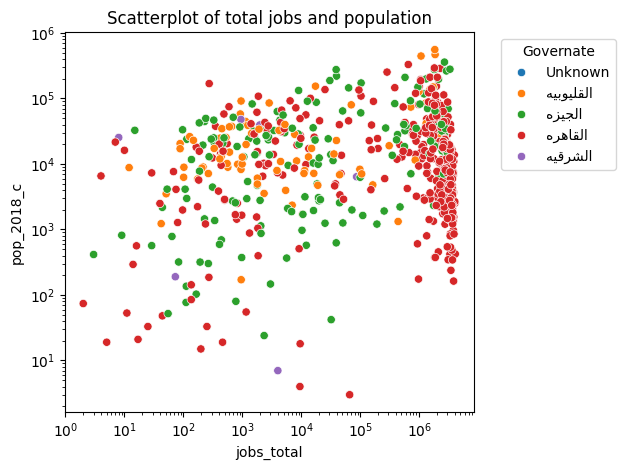

In [12]:
fig, ax = plt.subplots()

sns.scatterplot(data= Main_DF, x= "jobs_total", y= "pop_2018_c", hue= "name_gov_ar_fixed", ax= ax)
plt.yscale("log")
plt.xscale("log")

ax.legend(title= "Governate", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title("Scatterplot of total jobs and population")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("jobs_total")
ax.set_ylabel("pop_2018_c")

plt.tight_layout()
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\Scatterplot_Proj.svg', bbox_inches='tight')
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\Scatterplot_Proj.png', dpi= 600, bbox_inches='tight')
plt.show()

In [13]:
Main_DF.drop("name_gov_ar_fixed", axis= 1, inplace= True)

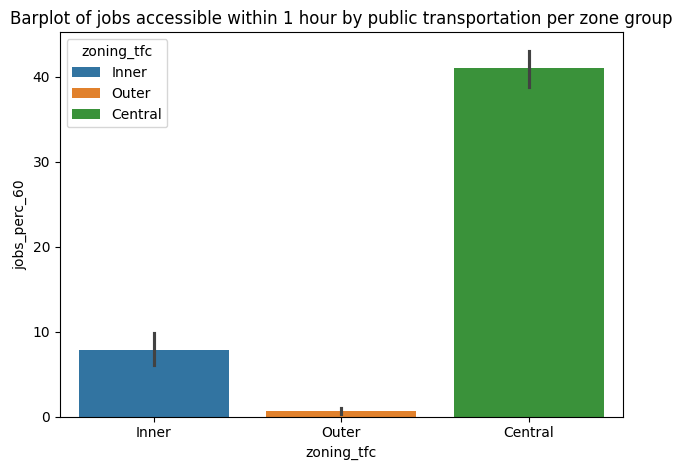

In [14]:
fig, ax = plt.subplots()

sns.barplot(Dropped_Empty_DF, x= "zoning_tfc", y= "jobs_perc_60", legend= True, hue= "zoning_tfc", ax= ax)

ax.set_title("Barplot of jobs accessible within 1 hour by public transportation per zone group")
ax.set_xlabel("zoning_tfc")
ax.set_ylabel("jobs_perc_60")

plt.tight_layout()
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\Barplot_Proj.svg', bbox_inches='tight')
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\Barplot_Proj.png', dpi= 600, bbox_inches='tight')
plt.show()

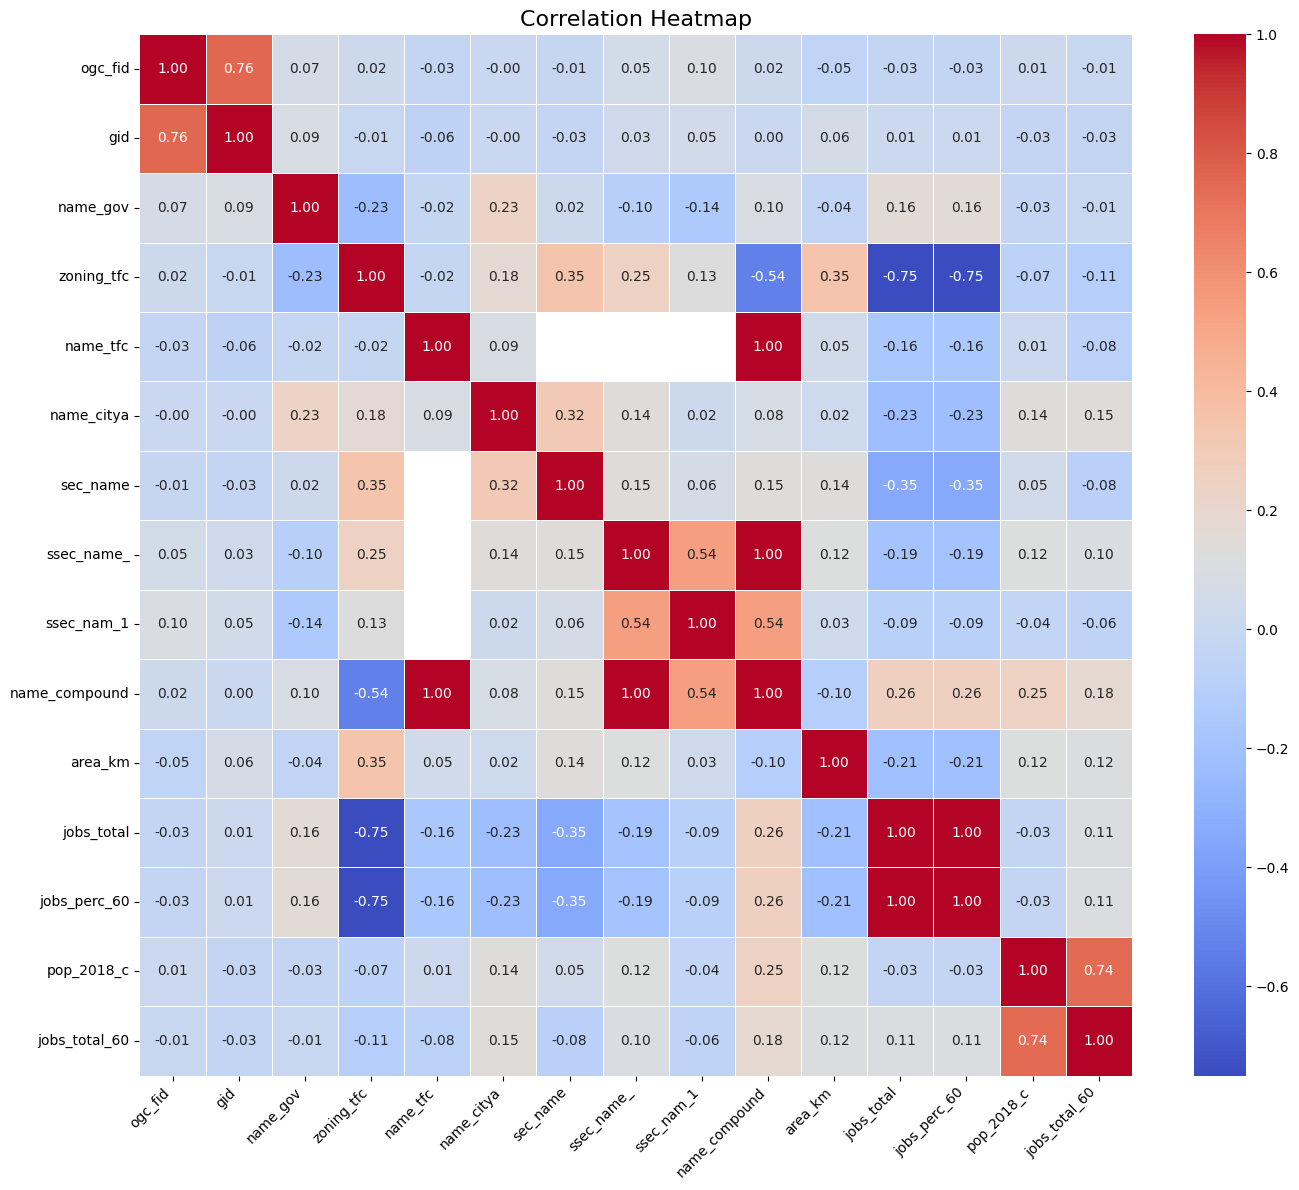

In [15]:
Heatmap_DF = Main_DF.copy()

Heatmap_DF = Heatmap_DF.replace("Unknown", np.nan)
Heatmap_DF = Heatmap_DF.replace(to_replace=r'.*_x0000_.*', value=np.nan, regex=True)

for col in Categorical_Feats:
    Heatmap_DF[col] = Heatmap_DF[col].astype('category')
    
    Heatmap_DF[col] = Heatmap_DF[col].cat.codes.replace(-1, np.nan)

fig, ax = plt.subplots(figsize=(14, 12))

sns.heatmap(data=Heatmap_DF.corr(numeric_only=True), 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f", 
            linewidths=0.5,
            ax=ax)

ax.set_title("Correlation Heatmap", fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\Heatmap_Proj.svg', bbox_inches='tight')
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\Heatmap_Proj.png', dpi= 600, bbox_inches='tight')
plt.show()

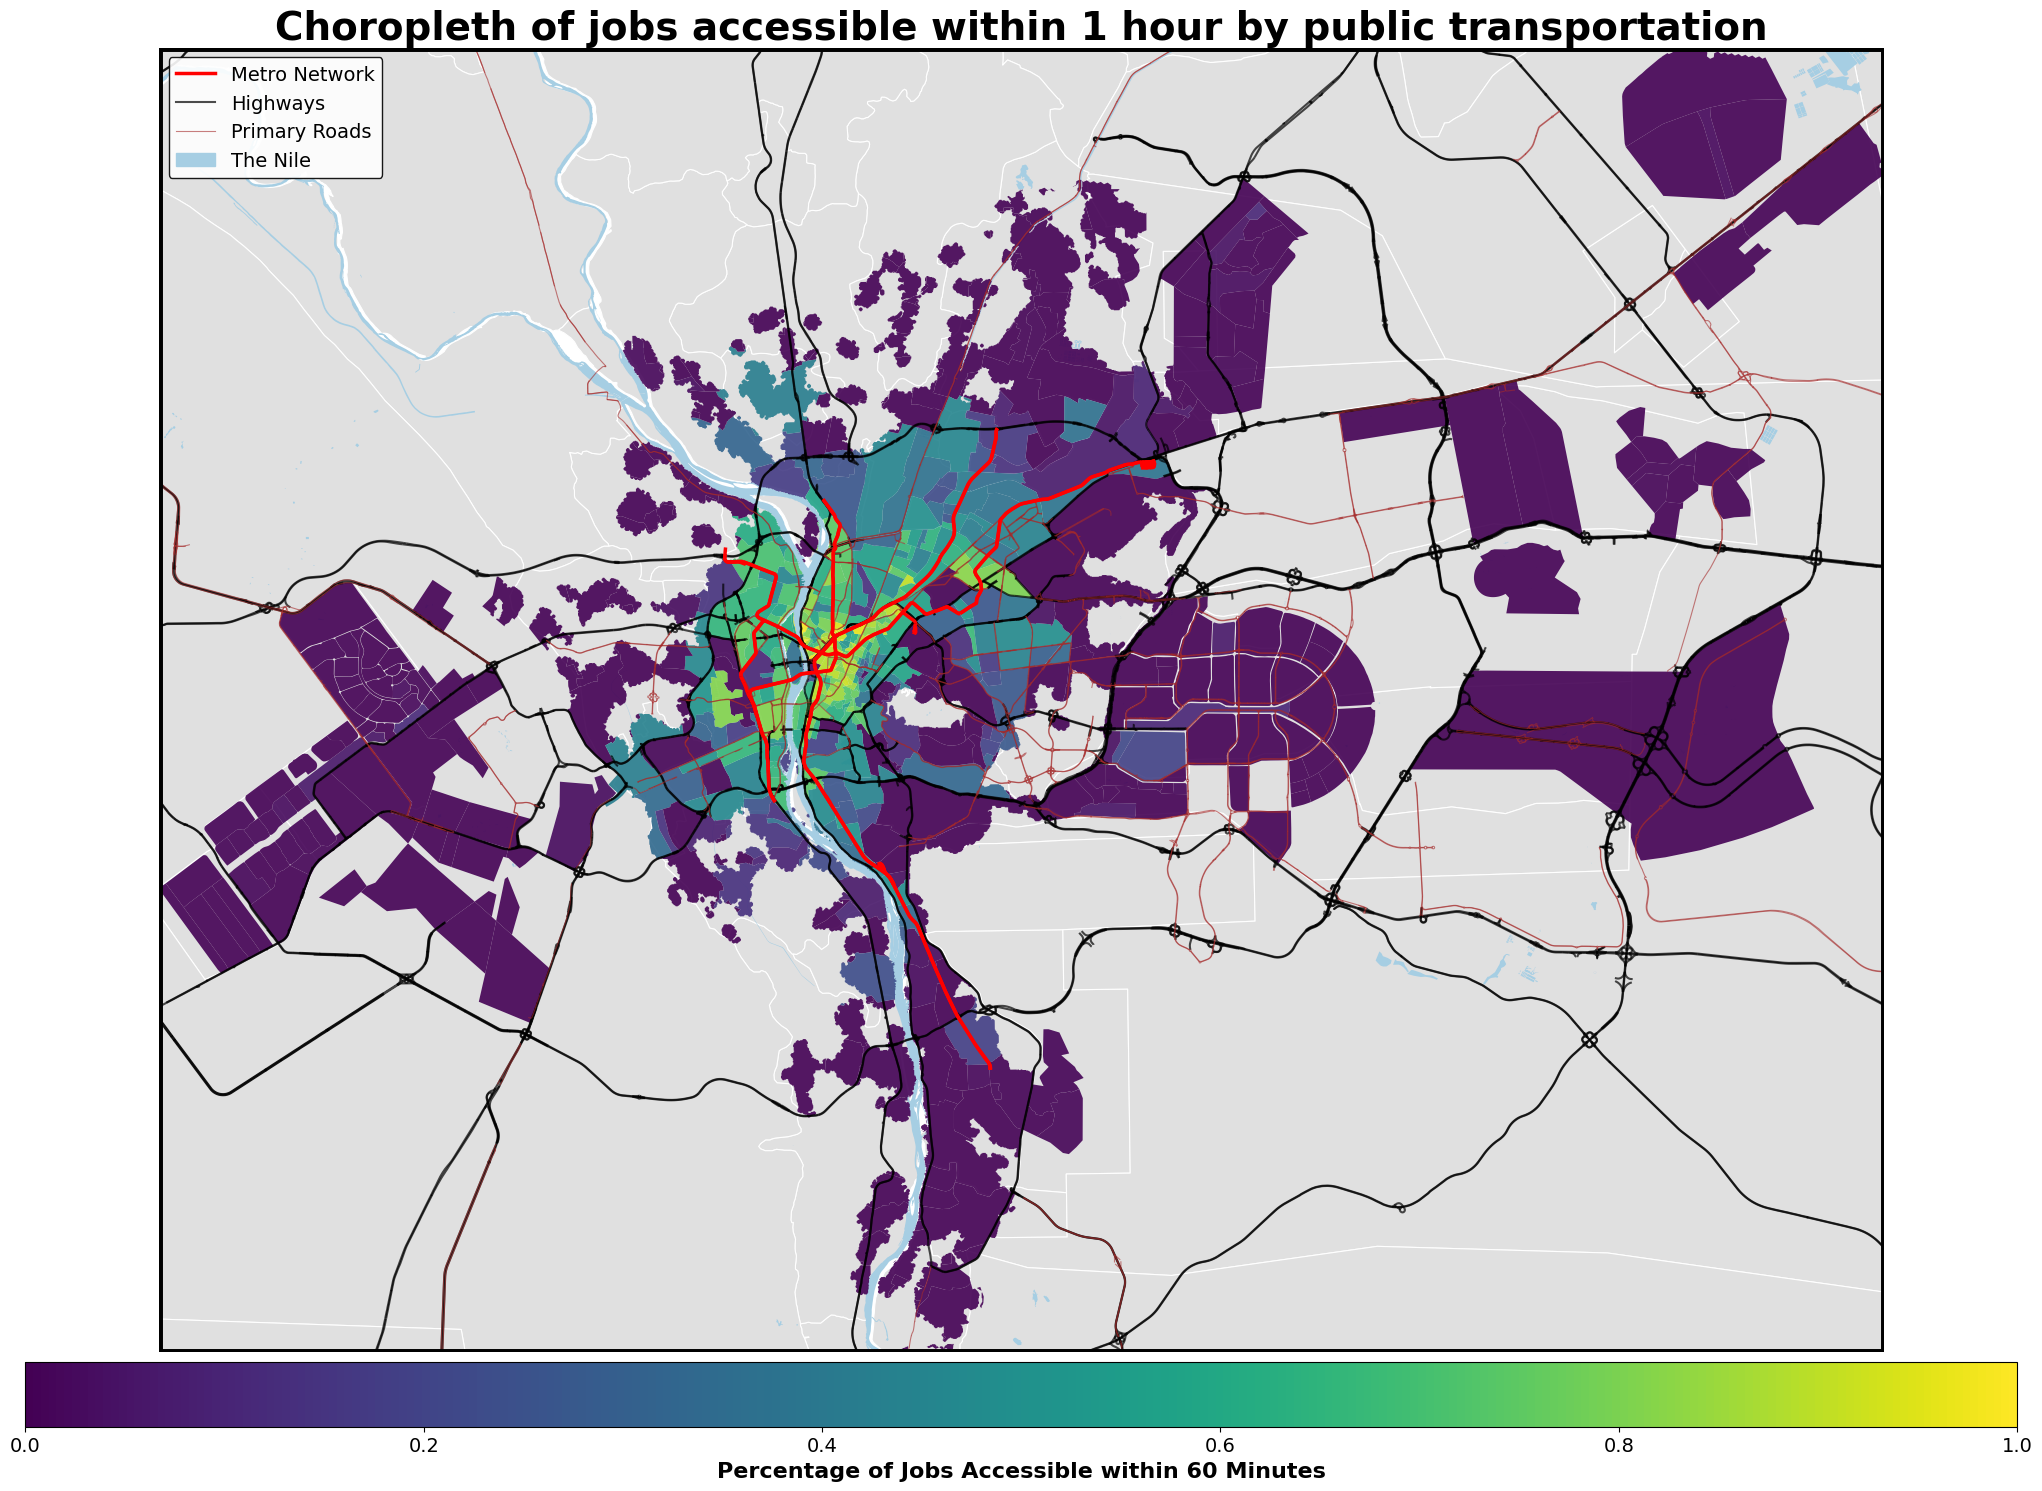

In [16]:
# Load files
gdf_shape = gpd.read_file(r"C:\Work\Programming\Projects\python\Probability & Statstics Proj\Chroropleth Shape Files\Study\cairo_accessibility_to_employment_opportunities.shp")

Merged_GDF = gdf_shape.merge(Main_DF, on='ogc_fid', how='left')

# Gather Data

# The Context (HDX Level 2 - Districts)
background = gpd.read_file(r"C:\Work\Programming\Projects\python\Probability & Statstics Proj\Chroropleth Shape Files\Raw\HDX Level 3 & 4\egy_admbnda_adm2_capmas_20170421.shp")

# The Data (Central Cairo Region Shapefile + Excel Data)
cairo_data = Merged_GDF.copy() 

# The Nile (Geofabrik Water)
nile = gpd.read_file(r"C:\Work\Programming\Projects\python\Probability & Statstics Proj\Chroropleth Shape Files\Raw\Geofabrik OSM\water\gis_osm_water_a_free_1.shp")

# The Metro (Geofabrik Railways)
railways = gpd.read_file(r"C:\Work\Programming\Projects\python\Probability & Statstics Proj\Chroropleth Shape Files\Raw\Geofabrik OSM\railways\gis_osm_railways_free_1.shp")

roads = gpd.read_file(r"C:\Work\Programming\Projects\python\Probability & Statstics Proj\Chroropleth Shape Files\Raw\Geofabrik OSM\roads\gis_osm_roads_free_1.shp")

target_roads = [
    'motorway', 'motorway_link',
    'trunk', 'trunk_link',
    'primary', 'primary_link'
]

# Sync Coordinate Systems
target_crs = cairo_data.crs
if background.crs != target_crs: background = background.to_crs(target_crs)
if nile.crs != target_crs: nile = nile.to_crs(target_crs)
if railways.crs != target_crs: railways = railways.to_crs(target_crs)

# Filter Railways to keep only the Metro
# 'fclass' contains 'subway' for Metro lines
metro = railways[railways['fclass'] == 'subway']

main_arteries = roads[roads['fclass'].isin(target_roads)]

# Clip the Nile to just the Cairo area
nile_clipped = gpd.clip(nile, cairo_data.total_bounds)
metro_clipped = gpd.clip(metro, cairo_data.total_bounds)

fig, ax = plt.subplots(figsize=(20, 14), constrained_layout=True)

# Plot Layers

# Layer 1: Background (Districts) - Remains at bottom
background.plot(
    ax=ax, color='#e0e0e0', edgecolor='white', linewidth=0.8, zorder=1
)

# Layer 2: Nile - Remains near bottom
nile_clipped.plot(
    ax=ax, color='#a6cee3', edgecolor='none', zorder=2
)

# Layer 3: Accessibility Data (The Heatmap)
choropleth = cairo_data.plot(
    column='jobs_perc_60',
    cmap='viridis',
    alpha=0.9,
    edgecolor='none',
    ax=ax,
    zorder=3
)

# Layer 4: Roads (Highways & Primary)
mask_hwy = main_arteries['fclass'].isin(['motorway', 'motorway_link', 'trunk', 'trunk_link'])
main_arteries[mask_hwy].plot(
    ax=ax, 
    color='black', 
    linewidth=1.5, 
    alpha=0.7, 
    zorder=4,
    label='Major Highways'
)

mask_primary = main_arteries['fclass'].isin(['primary', 'primary_link'])
main_arteries[mask_primary].plot(
    ax=ax, 
    color='brown', 
    linewidth=0.8, 
    alpha=0.6, 
    zorder=4,
    label='Primary Roads'
)

# Layer 5: Metro Lines
metro_clipped.plot(
    ax=ax, 
    color='red', 
    linewidth=2.5, 
    linestyle='-', 
    zorder=5, 
    label='Metro Lines'
)

# Borders, Legend, & Colorbar

# Remove standard axis spines but keep the box
ax.set_axis_off()

# Draw a thick black rectangle around the map view
# We do this by getting the current view limits
minx, miny, maxx, maxy = cairo_data.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Create a black rectangle patch matching the bounds
rect = mpatches.Rectangle((minx, miny), maxx-minx, maxy-miny, 
                          linewidth=5, edgecolor='black', facecolor='none', zorder=10)
ax.add_patch(rect)


# Split the axes to create a spot for the colorbar exactly at the bottom
divider = make_axes_locatable(ax)
cax_bar = divider.append_axes("bottom", size="5%", pad=0.1)

cbar = fig.colorbar(choropleth.collections[0], cax=cax_bar, orientation='horizontal')
cbar.set_label("Percentage of Jobs Accessible within 60 Minutes", fontsize=16, weight='bold')
cbar.ax.tick_params(labelsize=14)


# Plot a Custom Legend
legend_handles = [
    mlines.Line2D([], [], color='red', linewidth=2.5, label='Metro Network'),
    mlines.Line2D([], [], color='black', linewidth=1.5, alpha=0.7, label='Highways'),
    mlines.Line2D([], [], color='brown', linewidth=0.8, alpha=0.6, label='Primary Roads'),
    mpatches.Patch(color='#a6cee3', label='The Nile')
]

# Place legend in the top-left (or best corner) inside the box
leg = ax.legend(handles=legend_handles, loc='upper left', fontsize=14, frameon=True, facecolor='white', framealpha=0.9)
leg.get_frame().set_edgecolor('black')


# Save the Choropleth
plt.suptitle('Choropleth of jobs accessible within 1 hour by public transportation', fontsize=28, weight='bold', y=1.02)
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\Choropleth_Proj.svg', bbox_inches='tight')
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\Choropleth_Proj.png', dpi= 600, bbox_inches='tight')
plt.show()

Inferrential Statistics 

Refute One-Way ANOVA

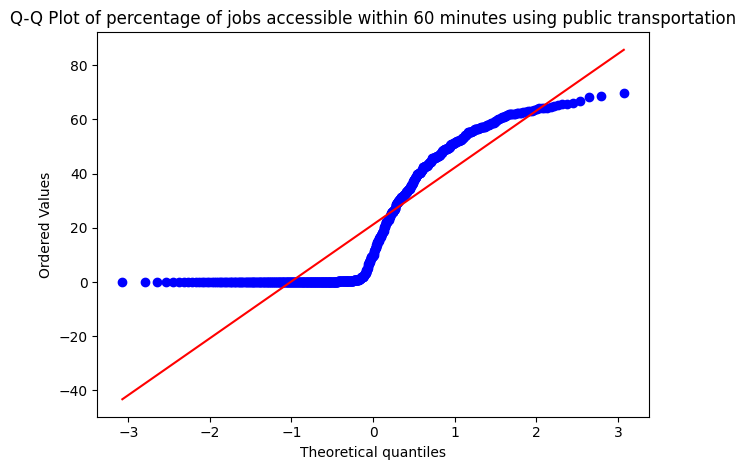

In [17]:
RQ1_DF = Inf_Stats_DF[["jobs_perc_60", "zoning_tfc", ]]

fig, ax = plt.subplots()

stats.probplot(RQ1_DF['jobs_perc_60'], dist="norm", plot=ax)

ax.set_title("Q-Q Plot of percentage of jobs accessible within 60 minutes using public transportation")

plt.tight_layout()
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\ANOVA_Refute_QPlot.svg', bbox_inches='tight')
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\ANOVA_Refute_QPlot.png', dpi= 600, bbox_inches='tight')
plt.show()

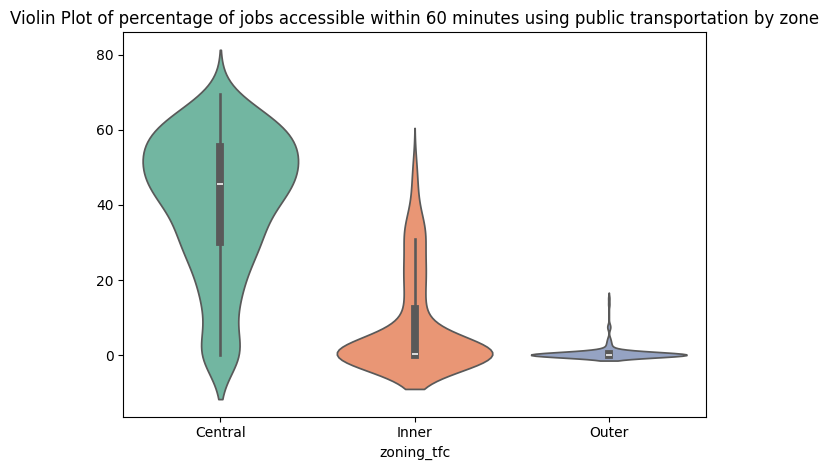

In [18]:
# Unused Extra Plot
fig, ax = plt.subplots()

Valid_Zones = RQ1_DF.zoning_tfc.unique()
Valid_Zones = Valid_Zones[Valid_Zones != "Unknown"]

sns.violinplot(x='zoning_tfc', y='jobs_perc_60', data=RQ1_DF, order= Valid_Zones ,palette='Set2', ax=ax)
ax.set_title('Violin Plot of percentage of jobs accessible within 60 minutes using public transportation by zone')
ax.set_ylabel('')

plt.tight_layout()
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\ANOVA_Refute_ViolinPlot.svg', bbox_inches='tight')
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\ANOVA_Refute_ViolinPlot.png', dpi= 600, bbox_inches='tight')
plt.show()

Durbin-Watson Statistic: 1.9379


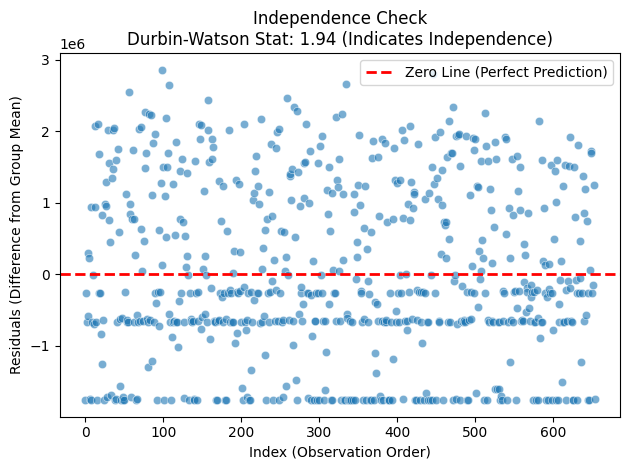

In [19]:
fig, ax = plt.subplots()

# Use OLS (Ordinary Least Squares) & Fit the model
model = ols('jobs_total ~ C(name_gov)', data=Inf_Stats_DF).fit()

# Get the Residuals (Errors)
residuals = model.resid

# Calculate Durbin-Watson Statistic
# Scale: 0 to 4. (Values near 2.0 indicate Independence)
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_stat:.4f}")

# Residuals Plot
sns.scatterplot(x=Inf_Stats_DF.index, y=residuals, alpha=0.6, ax= ax)
ax.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Line (Perfect Prediction)')
ax.set_title(f'Independence Check\nDurbin-Watson Stat: {dw_stat:.2f} (Indicates Independence)')
ax.set_xlabel('Index (Observation Order)')
ax.set_ylabel('Residuals (Difference from Group Mean)')
plt.legend()
plt.tight_layout()

plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\Refute_Residual_Plot_Proj.svg', bbox_inches='tight')
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\Refute_Residual_Plot_Proj.png', dpi= 600, bbox_inches='tight')
plt.show()

Kruksal Wallis H-Test Analysis

Kruskal-Wallis H-Test Results
H-Statistic: 386.3738
P-Value:     1.2589e-84
Result: (Reject Ho)
Conclusion: Job accessibility differs significantly between zones.

Post_Hoc Tests (Mann-Whitney U with Bonferroni Correction)
Inner vs Outer: P-adj = 4.32e-06 | Significant? YES
Inner vs Central: P-adj = 1.94e-53 | Significant? YES
Outer vs Central: P-adj = 1.05e-60 | Significant? YES


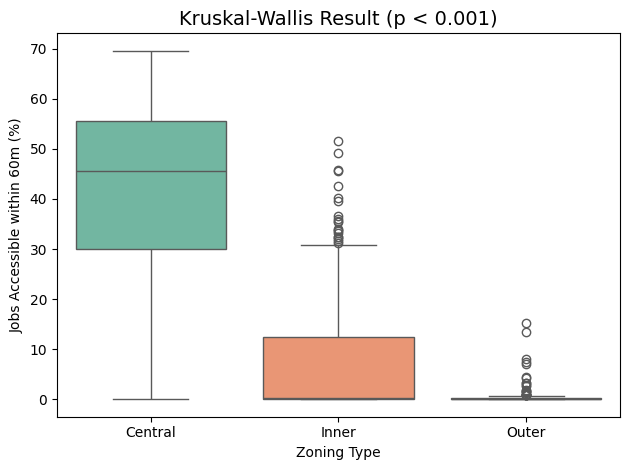

In [20]:
# Kruskal-Wallis H Test
# Ho: The medians of job accessibility are equal across all zones
# Ha: There is at least one median that differs from the rest
groups = [RQ1_DF[RQ1_DF['zoning_tfc'] == z]['jobs_perc_60'] for z in Valid_Zones]
h_stat, p_val = stats.kruskal(*groups)

print(f"Kruskal-Wallis H-Test Results")
print("="*50)
print(f"H-Statistic: {h_stat:.4f}")
print(f"P-Value:     {p_val:.4e}")

if p_val < 0.05:
    print("Result: (Reject Ho)")
    print("Conclusion: Job accessibility differs significantly between zones.")
else:
    print("Result: (Failure to Reject Ho)")
    print("Conclusion: Job accessibility is the same between zones.")

# Post-Hoc Mann-Whitney U Test (Pairwise)
# Only run this if the main test is significant
if p_val < 0.05:
    print("\n" + "="*50)
    print("Post_Hoc Tests (Mann-Whitney U with Bonferroni Correction)")
    print("="*50)
    
    pairs = [('Inner', 'Outer'), ('Inner', 'Central'), ('Outer', 'Central')]
    alpha = 0.05
    
    # Store results for plotting
    p_values = []
    
    for g1, g2 in pairs:
        data1 = RQ1_DF[RQ1_DF['zoning_tfc'] == g1]['jobs_perc_60']
        data2 = RQ1_DF[RQ1_DF['zoning_tfc'] == g2]['jobs_perc_60']
        
        # Mann-Whitney U test
        u_stat, p_u = stats.mannwhitneyu(data1, data2)
        
        # Bonferroni Correction (multiply p by number of pairs)
        p_adj = p_u * 3
        if p_adj > 1: p_adj = 1.0 # Cap at 1.0
        
        sig = "YES" if p_adj < alpha else "NO"
        print(f"{g1} vs {g2}: P-adj = {p_adj:.2e} | Significant? {sig}")

# Unused Extra Plot
fig, ax = plt.subplots()

sns.boxplot(x='zoning_tfc', y='jobs_perc_60', data=RQ1_DF, order= Valid_Zones, palette='Set2', ax=ax)
ax.set_title(f'Kruskal-Wallis Result (p < 0.001)', fontsize=14)
ax.set_ylabel('Jobs Accessible within 60m (%)')
ax.set_xlabel('Zoning Type')

plt.tight_layout()
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\Kurskal-Wallis_Proj.svg', bbox_inches='tight')
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\Kurskal-Wallis_Proj.png', dpi= 600, bbox_inches='tight')
plt.show()

Logistic Regression

In [21]:
RQ2_DF = Inf_Stats_DF[["pop_2018_c", "jobs_total", "jobs_perc_60"]]

# Turn the target variable into a 50/50 split to train a good logistic regression model
# using the median as the threshold as it is zero-inflated
# 1 <- Good Job Accessibility% | 0 <- Bad Job Accessibility%

decision_thres = RQ2_DF.jobs_perc_60.median()
print(f"Desired Median: {decision_thres}")

RQ2_DF["jobs_perc_60_cat"] = (RQ2_DF.jobs_perc_60 > decision_thres).astype(int)

RQ2_DF.drop("jobs_perc_60", axis= 1, inplace=True)

X = RQ2_DF.drop("jobs_perc_60_cat", axis= 1)
y = RQ2_DF.jobs_perc_60_cat

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

ModelObj = LogisticRegressionCV()
ModelObj.fit(X_train, y_train)


print('=' * 50)
print("Logistic Regression Results")
print('=' * 50)
print(f"Train Accuracy: {accuracy_score(y_train, ModelObj.predict(X_train))}")
print(f"Test Accuracy: {accuracy_score(y_test, ModelObj.predict(X_test))}")
print('=' * 50)
print(f"Train Percision: {precision_score(y_train, ModelObj.predict(X_train))}")
print(f"Test Percision: {precision_score(y_test, ModelObj.predict(X_test))}")
print('=' * 50)
print(f"Train Recall: {recall_score(y_train, ModelObj.predict(X_train))}")
print(f"Test Recall: {recall_score(y_test, ModelObj.predict(X_test))}")
print('=' * 50)
print(f"Train F1-Score: {f1_score(y_train, ModelObj.predict(X_train))}")
print(f"Test F1-Score: {f1_score(y_test, ModelObj.predict(X_test))}")
print('=' * 50)

# Plot the confusion matricies

Desired Median: 9.75
Logistic Regression Results
Train Accuracy: 1.0
Test Accuracy: 0.9949238578680203
Train Percision: 1.0
Test Percision: 1.0
Train Recall: 1.0
Test Recall: 0.9891304347826086
Train F1-Score: 1.0
Test F1-Score: 0.994535519125683


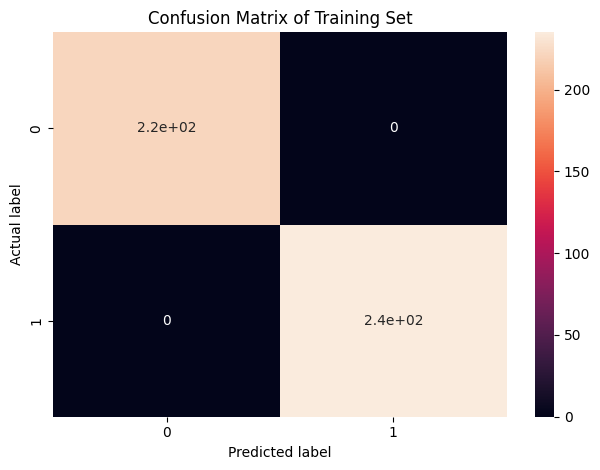

In [22]:
fig, ax = plt.subplots()

sns.heatmap(confusion_matrix(y_train, ModelObj.predict(X_train)), annot= True, ax= ax)
ax.set_title("Confusion Matrix of Training Set")
ax.set_ylabel('Actual label')
ax.set_xlabel('Predicted label')

plt.tight_layout()
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\ConfMatrixTrain_Proj.svg', bbox_inches='tight')
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\ConfMatrixTrain_Proj.png', dpi= 600, bbox_inches='tight')
plt.show()

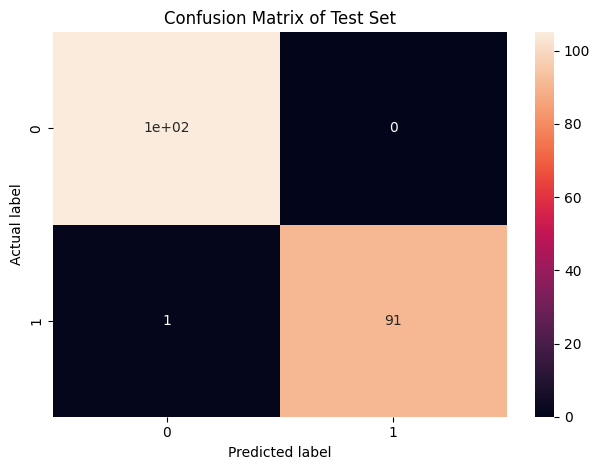

In [23]:
fig, ax = plt.subplots()

sns.heatmap(confusion_matrix(y_test, ModelObj.predict(X_test)), annot= True, ax= ax)
ax.set_title("Confusion Matrix of Test Set")
ax.set_ylabel('Actual label')
ax.set_xlabel('Predicted label')

plt.tight_layout()
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\ConfMatrixTest_Proj.svg', bbox_inches='tight')
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\ConfMatrixTest_Proj.png', dpi= 600, bbox_inches='tight')
plt.show()


Feature Coefficients (Importance):
      Feature  Coefficient
0  pop_2018_c     0.000034
1  jobs_total     0.000586


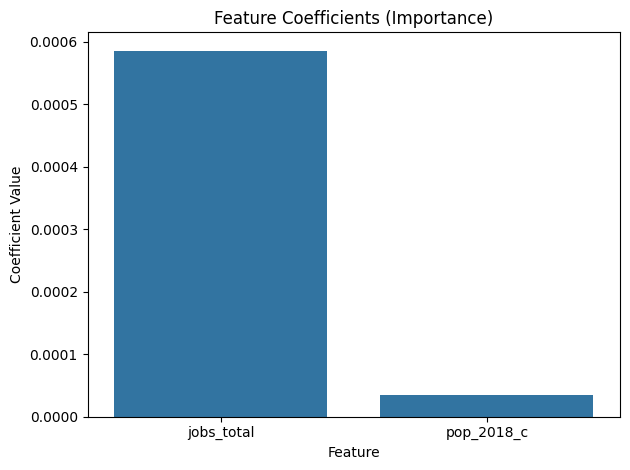

In [24]:
print("\nFeature Coefficients (Importance):")
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': ModelObj.coef_[0]})
print(coef_df)

fig, ax = plt.subplots()

sns.barplot(coef_df, x= "Feature", y= "Coefficient", legend= True, ax= ax, order= coef_df.sort_values("Coefficient", ascending= False).Feature)

ax.set_title("Feature Coefficients (Importance)")
ax.set_xlabel("Feature")
ax.set_ylabel("Coefficient Value")

plt.tight_layout()
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\FeatureBarPlot_Proj.svg', bbox_inches='tight')
plt.savefig(r'C:\Work\Programming\Projects\python\Probability & Statstics Proj\Resulting Plots\FeatureBarPlot_Proj.png', dpi= 600, bbox_inches='tight')
plt.show()

Pearson Correlation & Significance Test

In [25]:
RQ3_DF = Inf_Stats_DF[["pop_2018_c", "jobs_total"]]

# Ho: there is no association between the variables (True Correlation = 0)
# Ha: there is a significant association between the variables (True Correlation != 0)

# Due to the masisve number of samples & due to urban scaling statstics
# Urban planning follows a power-law scaling rule rather than a standard linear relationship
# That's why we use a log-log transform for Pearson correlation coeffcient to determine correctly.

corr_coefficient, p_val = stats.pearsonr(np.log(RQ3_DF.pop_2018_c[RQ3_DF.pop_2018_c > 0]), np.log(RQ3_DF.jobs_total[RQ3_DF.jobs_total > 0]))

print(f"Pearson Correlation Coefficient (r): {corr_coefficient:.4f}")
print(f"P-value: {p_val}")

alpha = 0.05
print("-" * 30)
if p_val < alpha: #type: ignore
    print("Result: Statistically Significant")
    print("We reject the Null Hypothesis (No association).")
    print("There is a relationship between Population and Jobs.")
else:
    print("Result: Not Statistically Significant")
    print("We fail to reject the Null Hypothesis.")

Pearson Correlation Coefficient (r): 0.1400
P-value: 0.0003566372240531272
------------------------------
Result: Statistically Significant
We reject the Null Hypothesis (No association).
There is a relationship between Population and Jobs.


F-Test

In [26]:
# Ho: The Variance of job opportunities between two selected governates are equal
# Ha: There is a significant difference in the variance of job opportunities in the two selected governates

RQ4_DF = Inf_Stats_DF[["name_gov", "jobs_total"]]

F_Stat_Tup = (
    {"eng1": "Giza", "eng2": "Cairo", "ar1": "الجيزه", "ar2": "القاهره"},
    {"eng1": "Giza", "eng2": "Sharkia", "ar1": "الجيزه", "ar2": "الشرقيه"},
    {"eng1": "Giza", "eng2": "Qalyubia", "ar1": "الجيزه", "ar2": "القليوبيه"},
    {"eng1": "Cairo", "eng2": "Sharkia", "ar1": "القاهره", "ar2": "الشرقيه"},
    {"eng1": "Cairo", "eng2": "Qalyubia", "ar1": "القاهره", "ar2": "القليوبيه"},
    {"eng1": "Sharkia", "eng2": "Qalyubia", "ar1": "الشرقيه", "ar2": "القليوبيه"}
)

In [27]:
def Cal_F_Test(eng1, eng2, ar1, ar2, Main_DF = RQ4_DF):
    alpha = 0.05
    Series1 = Main_DF.jobs_total[Main_DF.name_gov == ar1]
    Series2 = Main_DF.jobs_total[Main_DF.name_gov == ar2]
    
    Var1 = np.var(Series1, ddof=1)
    Var2 = np.var(Series2, ddof=1)

    if Var1 > Var2:
        f_stat = Var1 / Var2
        df1, df2 = len(Series1) - 1, len(Series2) - 1
        higher, lower = eng1, eng2
    else:
        f_stat = Var2 / Var1
        df1, df2 = len(Series2) - 1, len(Series1) - 1
        higher, lower = eng2, eng1

    p_value = 1 - stats.f.cdf(f_stat, df1, df2)
    
    H0_text = f"Var({eng1}) = Var({eng2})"
    
    if p_value < alpha:
        decision = "Reject H0"
        desc = f"{higher} has higher inequality (variance) than {lower}."
    else:
        decision = "Fail to Reject"
        desc = "No significant difference in inequality."

    print(f"{eng1} vs {eng2:<10} | {H0_text:<22} | {f_stat:<8.2f} | {p_value:<10.6f} | {decision:<14} | {desc}")

In [28]:
summary = RQ4_DF.groupby('name_gov')['jobs_total'].agg(['count', 'mean', 'std', 'var'])
summary = summary.loc[['الجيزه', 'القاهره', 'الشرقيه', 'القليوبيه']]
summary.index = ['Giza', 'Cairo','Sharkia', 'Qalyubia']

print('\n', summary.round(2))


           count        mean         std           var
Giza        186   662540.04  1060353.82  1.124350e+12
Cairo       383  1761532.01  1383859.95  1.915068e+12
Sharkia       7    13401.14    32398.44  1.049659e+09
Qalyubia     78   258000.90   614074.03  3.770869e+11


In [29]:
print(f"{'Comparison':<18} | {'Null Hypothesis (H0)':<22} | {'F-Stat':<8} | {'P-Value':<10} | {'Decision':<14} | {'Conclusion'}")
print("-" * 130)

for pair in F_Stat_Tup:
    Cal_F_Test(
        pair["eng1"], pair["eng2"], 
        pair["ar1"], pair["ar2"], 
        Main_DF=RQ4_DF
    )

Comparison         | Null Hypothesis (H0)   | F-Stat   | P-Value    | Decision       | Conclusion
----------------------------------------------------------------------------------------------------------------------------------
Giza vs Cairo      | Var(Giza) = Var(Cairo) | 1.70     | 0.000027   | Reject H0      | Cairo has higher inequality (variance) than Giza.
Giza vs Sharkia    | Var(Giza) = Var(Sharkia) | 1071.16  | 0.000000   | Reject H0      | Giza has higher inequality (variance) than Sharkia.
Giza vs Qalyubia   | Var(Giza) = Var(Qalyubia) | 2.98     | 0.000000   | Reject H0      | Giza has higher inequality (variance) than Qalyubia.
Cairo vs Sharkia    | Var(Cairo) = Var(Sharkia) | 1824.47  | 0.000000   | Reject H0      | Cairo has higher inequality (variance) than Sharkia.
Cairo vs Qalyubia   | Var(Cairo) = Var(Qalyubia) | 5.08     | 0.000000   | Reject H0      | Cairo has higher inequality (variance) than Qalyubia.
Sharkia vs Qalyubia   | Var(Sharkia) = Var(Qalyubia) | 359.2